# 2D conductive heat transport application: temperature diffusion in the near-field of an underground coal gasification reactor

Today, we study the **temperature diffusion in the near-field of an underground coal gasification reactor** in a coal seam of 20 m thickness. The simplified model used for this purpose has an extent of 20 m x 20 m (Fig. 1) and benefits from the reactor symmetry, reducing the overall model size by considering only a half domain, and thus the required computational time. 

<img src="07_Heat_flow_2D_application-Fig1.png" style="width:500px;"/> 
**Figure 1**: Geometry of a model of an idealised underground coal gasification reactor (quadrant with red dot) in a 20-m thick coal seam (not to scale).

Today's and next week's main **learning objectives** are:
-  Theory and application of the two main types of model boundary conditions
-  Application of convergence criteria for 2D temperature diffusion for automatic time step size determination
-  Implementation of time-dependent inner and outer boundary conditions

**The basis for the present model is our 2D conductive heat transport implementation completed in the last week, which we have *validated* using the analytical solution for 2D heat diffusion (see cells below).**


## Model parameters
-  Thermal diffusivity ($m^2/s$): $\alpha = K / (\rho \cdot c_p )$ with:
-  Heat conductivity: $K =  0.5\,W/m/K$
-  Specific heat capacity: $c_p = 1{,}130\,J/kg/K$
-  Density: $\rho = 1{,}281\,kg/m^3$
-  Initial temperature: $T_\text{ini} = 20\,^\circ \text{C}$
-  Gasification temperature: $T_\text{UCG} = 1000\,^\circ \text{C}$

## Convergence criterion for 2D diffusion PDE
The convergence criterion is derived from the explicit FDM approximation of the 2D diffusion equation by isolation of the $T_{i,j}$ terms on the RHS of the equation (we have just done this exercise by hand). Our $\Delta t$ is thus per definition small enough to allow energy (heat) flux per time step to be limited to a distance of $<\Delta x$ and $<\Delta y$.    

$\Delta t \lt \frac{1}{2 \alpha \left(\frac{1}{\Delta x^2}+\frac{1}{\Delta y^2}\right)}$

If this criterion is not maintained, oscillations in the numerical solution will occur. As we already know, these are likely to compromise our modelling results.

## Main model boundary conditions
We will apply the following two boundary conditions in our models:
-  **Neumann boundary condition**: $-K \frac{\partial T}{\partial x} = q$ and/or $-K \frac{\partial T}{\partial y} = q$ (with $q$ as constant source or sink term). If $q = 0\, W/m^3$, we are dealing with the so-called Neumann no-flow boundary condition (no heat diffusion across the model boundary or 'closed model boundary')
-  **Dirichlet boundary condition**: $T = \text{const.}$ (primary variable(s) are maintained constant what equals an open boundary)

We further differentiate between:
-  **Outer** boundary conditions (at the model boundary or boundaries)
-  **Inner** boundary conditions (inside the model and not at its boundaries)

Further boundary condition types available, such as the periodic boundary conditions represent time-dependent implementations of Neumann or Dirichlet boundary condition types.


### Exercises
1. Please implement the model geometry including the initial temperature and the inner boundary condition (Dirichlet type in the reactor with the given gasification temperature) based on the solution of last week's exercise.  Then, visualise your results for the time $t = 0\,s$. <br>
*Hint: general form of equation of a circle $y = y_M \pm \sqrt{r^2 - (x - x_M)^2}$, with $x_M$ and $y_M$ as circle centre coordinates and $r$ as circle radius.* 
2. Please adapt the second matplotlib figure to plot the temperature profiles along the coordinates $x=0\,m$ and $y= 10\,m$. 
3. Revise your code to maintain a constant inner Dirichlet boundary condition during the entire simulation time (50 days gasification operation).
4. Integrate the aforementioned convergence criterion to automagically calculate the time step size and required number of time steps using the parameters $t$, $\Delta x$, $\Delta y$ and $\alpha$.
5. Please implement the Neumann boundary condition ($-K \frac{\partial T}{\partial x} = 0$) at the left model boundary to represent the model symmetry in a mathematically correct manner. Which boundary conditions are now valid at all the other model boundaries?
6. Please implement the following operational scenarios and compare the maximum temperature diffusion after 50, 60, 75, 100 and 150 days qualitatively:
    1.  50 days of gasification followed by 100 days of natural cooling
    2.  50 days of gasification followed by 30 days of forced cooling by water (vapour) injection at $100\,^\circ \text{C}$
    
#### Hint
Try the method `pcolormesh` instead of `contour` with `alpha=1` (transparency off) for plotting. 

dt 28800 nt 240


/home/tk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in sqrt


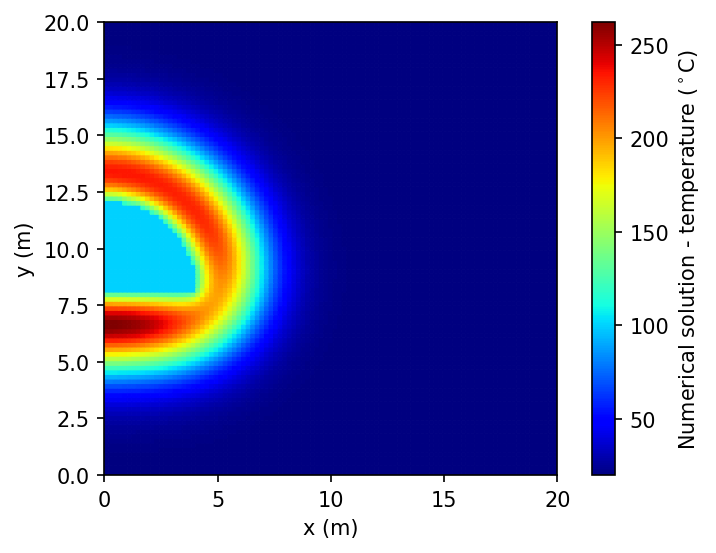

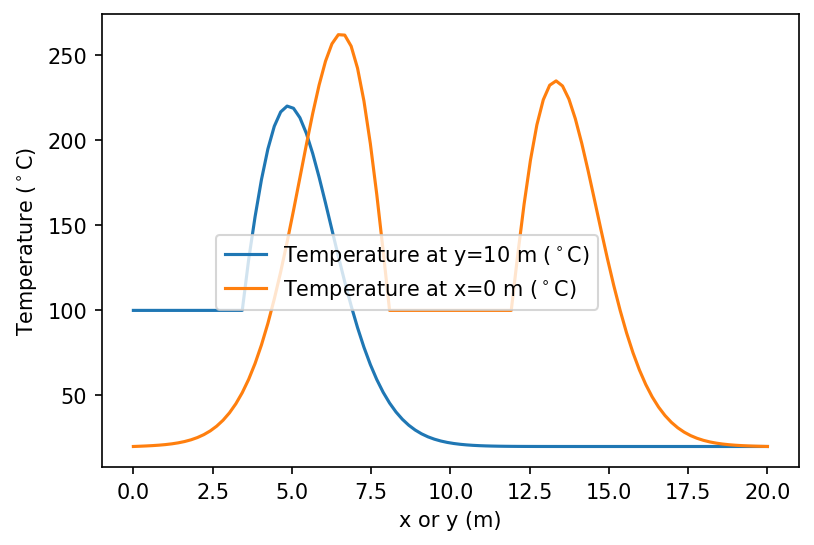

In [10]:
'''
    Application: 2D temperature diffusion in the vicinity of a gasification 
    reactor
    
    Parameters:
    lx : model length in x direction (m)
    ly : model length in y direction (m)
    nx : number of nodes in x direction (-)
    ny : number of nodes in y direction (-)
    dx : distance between nodes in x direction (m)
    dy : distance between nodes in y direction (m)
    nt : number of time steps (-)
    dt : time step size (s)
    alpha_x: thermal diffusivity in x direction (m^2/s)
    alpha_y: thermal diffusivity in y direction (m^2/s)
    T_ini : initial temperature (K)
    T_UCG : gasification temperature (K)
    T_COOL: water vapour temperature (K)
    t = nt * dt : time calculation for analytical solution (s)
    T : numpy matrix (array) with nx x ny elements of value 0
        results for time step n+1 (K)
    Tn : numpy matrix with results for time step n (K)
    B : numpy matrix for assignment of boundary conditions (-)
'''

# load required libraries
import numpy
from matplotlib import pyplot, cm
%matplotlib inline


# model parametrisation
lx = 20             # model length in x direction (m)
ly = 20             # model length in y direction (m)
nx = 100             # number of nodes in x direction (-)
ny = 100             # number of nodes in y direction (-)
dx = lx / (nx - 1)  # node distance in x direction (m)
dy = ly / (ny - 1)  # node distance in y direction (m)
alpha = 0.5 / ( 1281 * 1130 ) # coal thermal diffusivity (m^2/s)
T_UCG = 1000        # gasification temperature (°C)
T_COOL = 100        # temperature water injection (°C)
T_ini = 20          # initial temperature (°C)

# Mode of operation (cf. Exercise 6)
Mode = 'B' # A: 50 days gasification and 100 days natural cooling
           # B: 50 days gasification and 30 days forced cooling at 100°C

if Mode == 'A':
    t = 86400 * 150      # simulation time (s)
else:
    t = 86400 * 80       # simulation time (s)
    
    
# convergence criterion
dt = int(1/(2*alpha*(1/dx**2+1/dy**2))) # calculate integer dt via
                                        # convergence criterion
# adapt time step size to match desired simulation time
while t % dt != 0: # reduce dt to match modulo operation, so that t = dt*nt
    dt -= 1
nt = int(t/dt)          
print('dt', dt, 'nt', nt) # print for control (can be commented out)
    
# initialise matrices required for our calculations
T = numpy.ones((nx,ny))*T_ini   # numpy matrix (array) wth nx x ny elements
                           # results for time step (n+1)
Tn = numpy.ones((nx,ny))   # results for time step (n)
B = numpy.zeros((nx,ny))   # boundary condition matrix
                           # B = 1 : Dirichlet b.c.
                           # B = 0 : no b.c. (regular element)
#B[nx-1,:] = 1 # right boundary 
#B[:,0] = 1  # lower boundary
#B[:,ny-1] = 1 # upper boundary

# set initial and boundary conditions by means of circle equation for t=0
for i in range(0, nx): # iterate over all i nodes [0,nx]
    for j in range(0, ny): # Iterate over all j nodes [0,ny]
        if j*dy <= 8 + numpy.sqrt(16-numpy.power((i*dx),2)) and \
            j*dy >= 8:
            T[i,j] = T_UCG
            B[i,j] = 1

# FDM approximation of 2D PDE
cooling_started = 0 # cooling flag

for n in range(1,nt+1):  # iterate over nt time steps
    Tn = T.copy()        # copy T values from previous time step into Tn 
    for i in range(0, nx-1): # iterate over i nodes 
                             # (Dirichlet b.c. right)
         for j in range(1, ny-1): # iterate over j nodes
                                  # (Dirichlet b.c. top and bottom)
            if B[i,j] == 0:
                if i == 0:
                    T[i,j] = Tn[i,j] + \
                        alpha * dt / dx**2 * \
                        (Tn[i+1,j] - Tn[i,j]) + \
                        alpha * dt / dy**2 * \
                        (Tn[i,j+1] - 2 * Tn[i,j] + Tn[i,j-1]) 
                else:
                    T[i,j] = Tn[i,j] + \
                        alpha * dt / dx**2 * \
                        (Tn[i+1,j] - 2 * Tn[i,j] + Tn[i-1,j]) + \
                        alpha * dt / dy**2 * \
                        (Tn[i,j+1] - 2 * Tn[i,j] + Tn[i,j-1]) 
    
    # if gasification period is over, activate cooling period
    if n * dt >= 86400 * 50 and cooling_started == 0:
        if Mode == 'A':        # natural cooling
            B[:,:] = 0       # remove Dirichlet b.c. at reactor elements
        else:
            T[B==1] = 100    # forced cooling, set 100°C at reactor elements
        cooling_started = 1  # set flag to avoid calling this part again

# Neumann b.c. clarification        
# (T[i+1] - 2 * T[i] + T[i-1]) = 
# (T[i+1] - T[i]) - (T[i] - T[i-1])

                
# plotting the results
x = numpy.linspace(0, lx, nx)
y = numpy.linspace(0, ly, ny)

# 2D plot
fig = pyplot.figure(dpi=150)
X, Y = numpy.meshgrid(x, y)
ax = fig.gca(aspect=1)
nux = ax.pcolormesh(X, Y, numpy.transpose(T), cmap=cm.jet,
linewidths=0.5, alpha=1, antialiased=True, linestyles='solid');
cbnux = fig.colorbar(nux);
cbnux.set_label('Numerical solution - temperature ($^\circ$C)')
#pyplot.title('Temperature distribution (t='+str(n*dt/86400)+' days)');
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# cross sections plot
xx = numpy.linspace(0,lx,nx)
fig2 = pyplot.figure(dpi=150)
pyplot.plot(xx,T[:,int((ny-1)/2)], label='Temperature at y=10 m ($^\circ$C)');
pyplot.plot(xx,T[0,:], label='Temperature at x=0 m ($^\circ$C)');
#pyplot.title('Temperature distribution (t='+str(nt*dt/86400)+' days)');
pyplot.xlabel('x or y (m)');
pyplot.ylabel('Temperature ($^\circ$C)');
fig2.legend(loc='center');

In [ ]:
# Convergence criterion test cell (we used this to test the implementation)

dt = int(1/(2*alpha*(1/dx**2+1/dy**2))) # calculate integer dt via
                                        # convergence criterion
print('initial dt:', dt)    
dt_max = 1/(2*alpha*(1/dx**2+1/dy**2)) # calculate integer dt via
# adapt time step size to match desired simulation time
while t % dt != 0: # reduce dt to match modulo operation, so that t = dt*nt
    dt -= 1
    #print('reduced dt:', dt)
nt = int(t/dt)          
print('dt', dt, 'nt', nt, 'dt_max', dt_max) # print for control 
                                            # (can be commented out)